In [33]:
import os
import json
import motornet as mn
import numpy as np

from create_network import create_network

from plotting_functions import hand_to_joints 
from plotting_functions import plot_simulations
from plotting_functions import plot1trial
from plotting_functions import print_training_log

from test_network import null_test
from test_network import curl_test

In [3]:
## create the network
nn = create_network()

2023-02-06 13:30:33.875317: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-06 13:30:33.875372: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-06 13:30:33.875425: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (akebono): /proc/driver/nvidia/version does not exist
2023-02-06 13:30:33.876126: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [70]:
# TRAIN NETWORK IN A NULL FIELD

n_t = 100
n_batches = 1 #256
batch_size = 64

#to store results after each fit
myLargeArr = np.empty((0, 100, 4), float)
myTargetArr = np.empty((0, 100, 4), float)
#print(myLargeArr.shape)

# this callback logs training information for each batch passed, rather than for each epoch.
callbacks = [mn.nets.callbacks.BatchLogger()]
for i in range(5):
    print(i + 1)
    condition = "train"
    nn.task.angular_step = 15 # reset to original amount
    
    # generate inputs and initial states based on the task
    [inputs, targets, init_states] = nn.task.generate(n_timesteps=n_t, batch_size=batch_size*n_batches, condition=condition, ff_coefficient=0) #coefficient = 0 for null field   
    # fit the model
    # verbose = 1 will print the training losses
    h = nn.fit(x=[inputs, init_states], y=targets, verbose=1, epochs=1, batch_size=batch_size, shuffle=False, callbacks=callbacks)

    ## collect results to assess learning curve
    #get results
    condition = "test"
    n_mov_circle = 8 # number of movement directions around the unit circle
    n_t = 100
    nn.task.angular_step = 360 / n_mov_circle

    [inputs, targets, init_states] = nn.task.generate(n_timesteps=n_t, batch_size=n_mov_circle, condition=condition)
    results = nn([inputs, init_states], training=False)

    #store results 
    myLargeArr = np.append(myLargeArr, results['cartesian position'], axis=0)
    myTargetArr = np.append(myTargetArr, targets, axis=0)




1
1/1 [==============================] - 0s 76ms/step - loss: 0.0905 - position_loss: 0.0370 - gru_regularizer_loss: 0.3967 - l2_xdx_activation_loss: 0.0042
dict_keys(['inputs', 'ff_coefficient'])
(8, 100, 4)
2
1/1 [==============================] - 0s 75ms/step - loss: 0.0713 - position_loss: 0.0292 - gru_regularizer_loss: 0.3486 - l2_xdx_activation_loss: 0.0031
dict_keys(['inputs', 'ff_coefficient'])
(8, 100, 4)
3
1/1 [==============================] - 0s 73ms/step - loss: 0.0938 - position_loss: 0.0384 - gru_regularizer_loss: 0.4005 - l2_xdx_activation_loss: 0.0044
dict_keys(['inputs', 'ff_coefficient'])
(8, 100, 4)
4
1/1 [==============================] - 0s 76ms/step - loss: 0.0897 - position_loss: 0.0369 - gru_regularizer_loss: 0.3850 - l2_xdx_activation_loss: 0.0040
dict_keys(['inputs', 'ff_coefficient'])
(8, 100, 4)
5
1/1 [==============================] - 0s 76ms/step - loss: 0.0922 - position_loss: 0.0376 - gru_regularizer_loss: 0.3820 - l2_xdx_activation_loss: 0.0044
dict_ke

In [67]:
print(myLargeArr.shape)
print(type(myLargeArr))
print(myTargetArr.shape)
print(type(myTargetArr))

(40, 100, 4)
<class 'numpy.ndarray'>
(40, 100, 4)
<class 'numpy.ndarray'>


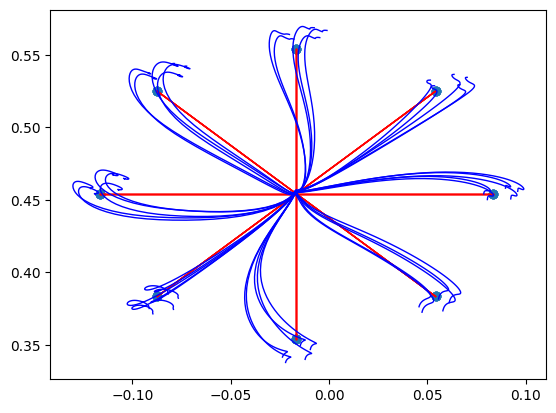

In [71]:
import matplotlib.pyplot as plt
target_xy = myTargetArr
xy = myLargeArr
target_x = target_xy[:, -1, 0]
target_y = target_xy[:, -1, 1]
plt.figure()
nmov,ntime,_ = np.shape(xy)

for i in range(nmov):
    plt.plot(target_xy[i,:,0],target_xy[i,:,1],color="r",linewidth=1.0)

for i in range(nmov):
    plt.plot(xy[i,:,0],xy[i,:,1],color="b",linewidth=1.0)
plt.scatter(target_x, target_y)

In [42]:
cartesian_results_filename = "cartesian_position.npy"
np.save(cartesian_results_filename, myLargeArr)

In [43]:
newArr = np.load("cartesian_position.npy")

In [44]:
print(newArr.shape)

(24, 100, 2)


In [ ]:
# SAVE MODEL PARAMETERS
folderLocation = "save_NF1" + os.path.sep

# view training log
training_log = callbacks[0].history
print_training_log(folderLocation, log=training_log)

# save the trained model
weight_file = folderLocation + "weights.h5"
log_file = folderLocation + "log.json"
# data_file = "save_NF1" + os.path.sep + "data.pickle"
# cfg_file = "save_NF1" + os.path.sep + "cfg"

# save model weights
nn.save_weights(weight_file, save_format='h5')

# save model configuration ### NOT NEEDED
# if not os.path.isfile(cfg_file + ".json"):
#   nn.save_model(cfg_file)

# save training history (log)
with open(log_file, 'w') as file:
    training_log = callbacks[0].history
    json.dump(training_log, file)

print("Done saving null trained model.")

In [ ]:
# TESTING THE NULL-TRAINED NETWORK

null_test(folderLocation, nn) #test in a null field
curl_test(folderLocation, nn) #test in a curl field